# Estudio comparativo de algoritmos en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos UCB en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Authors: Jesús Verdú Chacón
             Jorge López Abad
    Emails: jesus.v.c@um.es
            jorge.lopeza@um.es
    Date: 2025/01/29

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



## Preparación del entorno


In [ ]:
#@title Copiar el repositorio.

!git clone https://github.com/JyJumu/EML.git
!cd EML/

Cloning into 'EML'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 272 (delta 49), reused 0 (delta 0), pack-reused 196 (from 1)
Receiving objects: 100% (272/272), 78.56 KiB | 13.09 MiB/s, done.
Resolving deltas: 100% (158/158), done.


In [ ]:
!ls -R /content/EML


/content/EML:
algorithms  arms  plotting  README.md

/content/EML/algorithms:
algorithm.py  epsilon_greedy.py  gradiente.py  __init__.py  softmax.py	ucb1.py  ucb2.py

/content/EML/arms:
armbernoulli.py  armbinomial.py  armnormal.py  arm.py  bandit.py  __init__.py

/content/EML/plotting:
__init__.py  plotting.py


In [ ]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
#sys.path.append('/content/EML')
sys.path.append('/content/EML')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List
import matplotlib.pyplot as plt

from algorithms import Algorithm, EpsilonGreedy, UCB1, UCB2
from arms import ArmNormal, Bandit, ArmBernoulli, ArmBinomial
from plotting import plot_average_rewards, plot_optimal_selections, plot_regret, plot_arm_statistics, plot_arm_num_choices


['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/EML']


## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recompensas obtenidas en esas 500 veces.

In [ ]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    arm_stats = np.zeros((len(algorithms), bandit.k))  # Matriz para almacenar las ganancias de cada brazo por algoritmo.

    num_chocices_arm = np.zeros((len(algorithms), bandit.k))  # Matriz para almacenar el número de veces que se ha elegido cada brazo por algoritmo.

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz para almacenar el regret acumulado.

    optimal_reward = bandit.pull_arm(optimal_arm)

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for idx, algo in enumerate(algorithms):
            if isinstance(algo,UCB1):
                for step in range(steps):
                    chosen_arm = algo.select_arm(step) # Seleccionar un brazo según la política del algoritmo.
                    num_chocices_arm[idx, chosen_arm] += 1 # Actualizar el número de veces que se ha elegido cada brazo por algoritmo.
                    reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                    arm_stats[idx, chosen_arm] += reward # Actualizar la ganancia del brazo seleccionado por el algoritmo.
                    algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                    rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                    total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                    # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                    if chosen_arm == optimal_arm:
                        optimal_selections[idx, step] += 1

                    regret_accumulated[idx, step] = step*optimal_reward - total_rewards_per_algo[idx]

            elif isinstance(algo,UCB2):
                step = 0
                while step < steps:
                    chosen_arm, num_veces = algo.select_arm(step) # Seleccionar un brazo según la política del algoritmo.

                    i = 0
                    while (step < steps) and (i < num_veces):
                        num_chocices_arm[idx, chosen_arm] += 1 # Actualizar el número de veces que se ha elegido cada brazo por algoritmo.
                        reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                        arm_stats[idx, chosen_arm] += reward # Actualizar la ganancia del brazo seleccionado por el algoritmo.
                        algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                        rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                        total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.
                        regret_accumulated[idx, step] = step*optimal_reward - total_rewards_per_algo[idx]

                        if chosen_arm == optimal_arm:
                            optimal_selections[idx, step] += 1

                        step += 1
                        i += 1


                    # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm



    rewards /= runs

    # Calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100
    regret_accumulated /= runs
    arm_stats /= runs
    num_chocices_arm /= runs

    return rewards, optimal_selections, regret_accumulated, arm_stats, num_chocices_arm


## Ejecución del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definimos un algoritmo UCB
algorithms = [UCB1(k=k, c=0.1), UCB1(k=k, c=0.5), UCB1(k=k, c=1), UCB2(k=k, alfa=0.3), UCB2(k=k, alfa=0.6), UCB2(k=k, alfa=0.9)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regret_accumulated, arm_stats, num_choices_arm = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


In [ ]:
print(num_choices_arm)
for i in range(len(num_choices_arm)):
   print(sum(num_choices_arm[i]))

[[  1.      1.      1.      1.      1.012   1.162  90.972 900.774   1.008
    1.072]
 [  1.      1.      1.      1.      1.108   1.672  27.756 962.888   1.128
    1.448]
 [  1.      1.      1.      1.052   1.94    3.77   18.922 966.112   1.958
    3.246]
 [  1.      1.      1.      1.      1.062   1.672  24.552 966.266   1.064
    1.384]
 [  1.      1.      1.      1.      1.068   1.78   27.462 963.056   1.098
    1.536]
 [  1.      1.      1.      1.      1.2     2.1    18.254 971.422   1.188
    1.836]]
1000.0
1000.0
999.9999999999999
999.9999999999999
999.9999999999999
1000.0


In [ ]:
regret_accumulated

array([[ 1.15400825e-03,  1.95637460e-02,  3.88114165e-02, ...,
         1.15857370e+00,  1.15931490e+00,  1.16095458e+00],
       [-4.21319511e-03,  1.32195045e-02,  3.19424074e-02, ...,
         9.80801235e-01,  9.85248092e-01,  9.87170541e-01],
       [-1.08560221e-03,  1.17179524e-02,  2.80677772e-02, ...,
         1.10161986e+00,  1.10243322e+00,  1.10376725e+00],
       [-4.13469360e-03,  1.01210874e-02,  2.76447349e-02, ...,
         1.01397025e+00,  1.01680919e+00,  1.02076628e+00],
       [-4.60365503e-03,  7.82899570e-03,  2.84908873e-02, ...,
         1.09720807e+00,  1.09892297e+00,  1.10186953e+00],
       [-5.08287493e-03,  8.88430689e-03,  2.41832414e-02, ...,
         1.08532487e+00,  1.08638864e+00,  1.08959639e+00]])

## Definimos las funciones para dibujar

## Visualización de los resultados

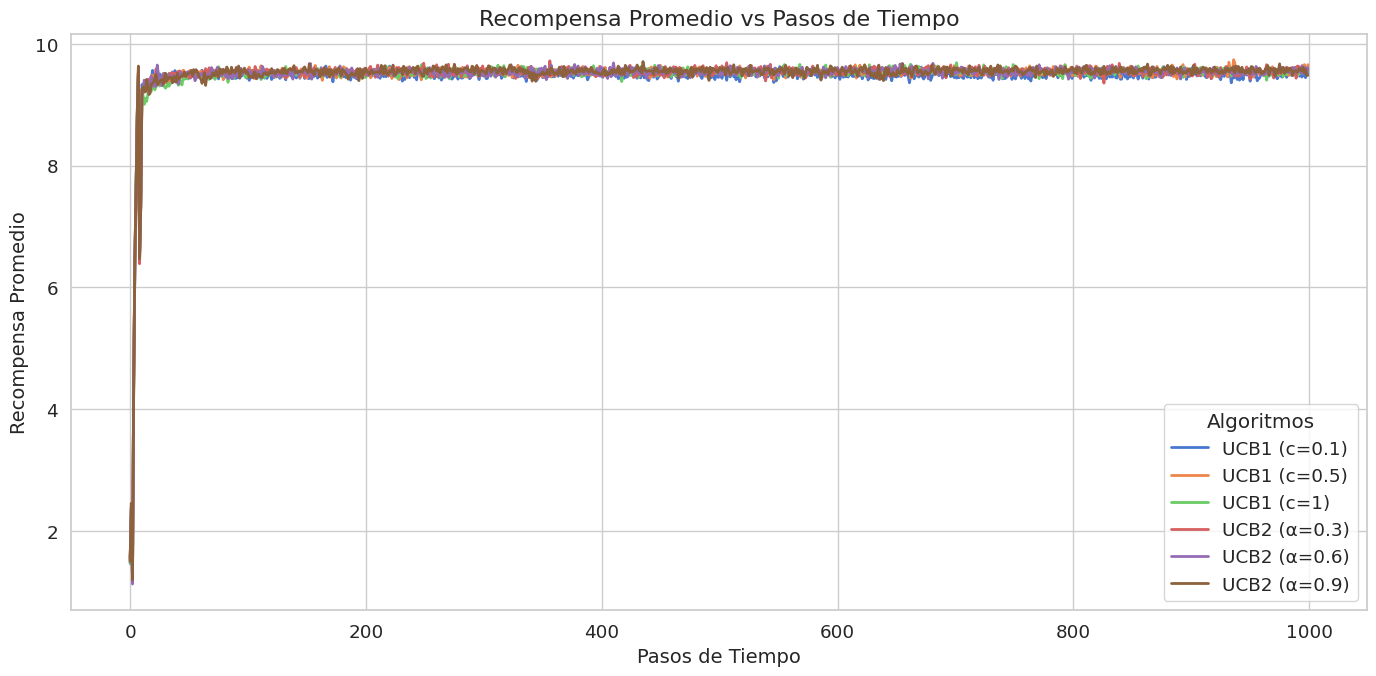

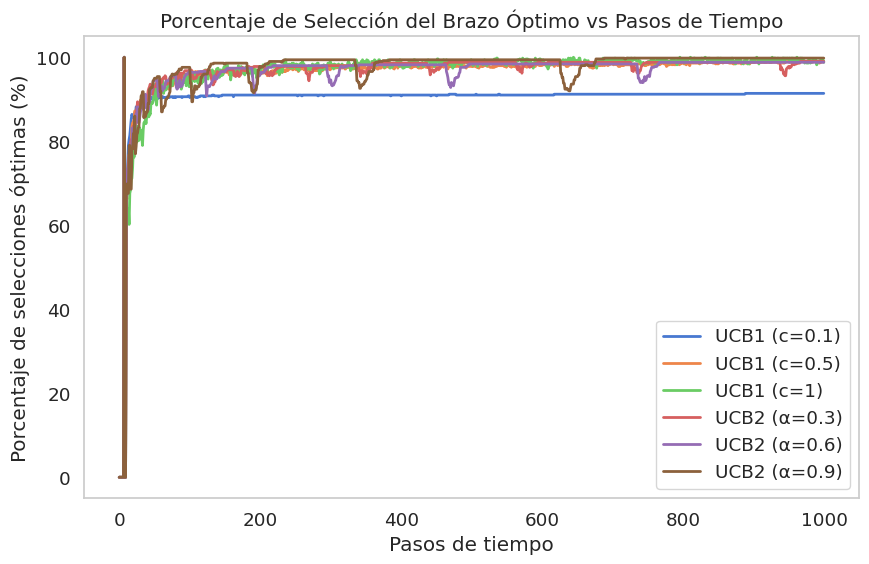

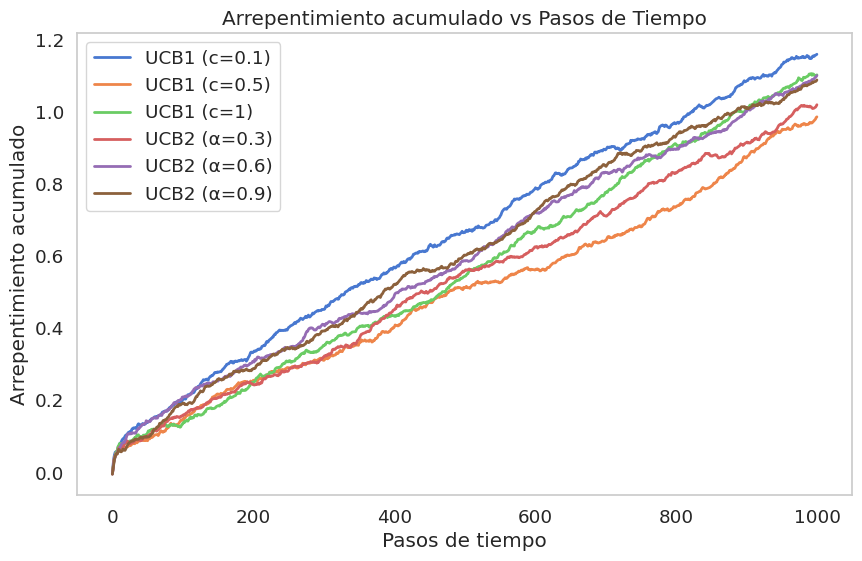

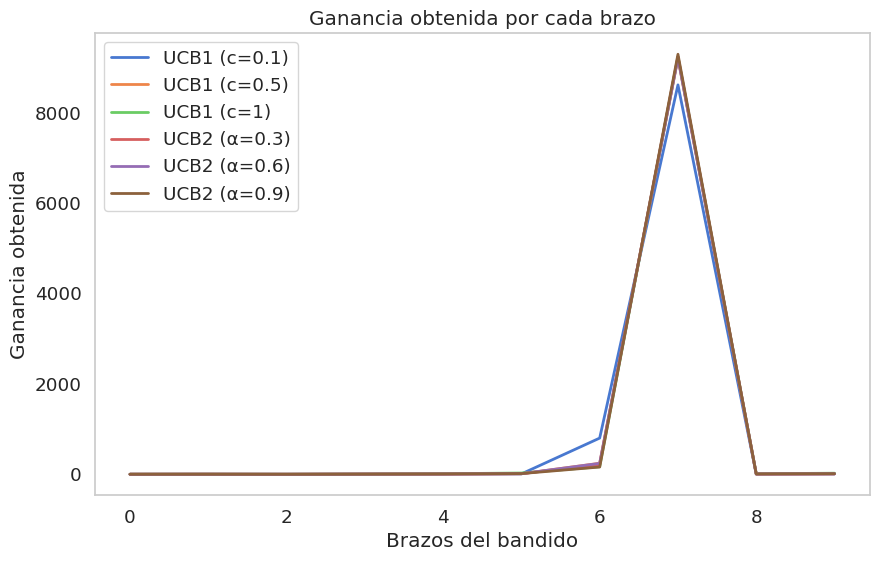

In [ ]:
# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)
plot_optimal_selections(steps, optimal_selections, algorithms)
plot_regret(steps, regret_accumulated, algorithms)
plot_arm_statistics(arm_stats, algorithms, k)


In [ ]:
if isinstance(algorithms[0], Algorithm):
    print("El objeto es una instancia de Algorithm")
else:
    print("El objeto NO es una instancia de Algorithm")


El objeto es una instancia de Algorithm


### Análisis detallado de la imagen

La imagen muestra un gráfico de líneas titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias del algoritmo **ε-Greedy** en un entorno de multi-armed bandit. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración).
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Crecimiento de la recompensa promedio:**
   - La línea **verde (ε=0.1)** alcanza rápidamente una recompensa promedio alta, lo que indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos.
   - La línea **naranja (ε=0.01)** también muestra un crecimiento, pero más lento en comparación con ε=0.1.
   - La línea **azul (ε=0)** se mantiene en un nivel bajo de recompensa, lo que sugiere que no logra encontrar el mejor brazo porque no explora nuevas opciones.

---





## Conclusiones

Hemos estudiado un  **experimento de toma de decisiones secuenciales**, modelado con un **Multi-Armed Bandit (MAB)**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandit) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo epsilon-greedy, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
El algoritmo **ε-Greedy** equilibra la exploración y la explotación:
- **Explotación (ε=0)**: Siempre elige la mejor opción conocida, pero si inicialmente se selecciona un brazo subóptimo, nunca descubrirá otras opciones más rentables.
- **Exploración (ε>0)**: Introduce aleatoriedad en la selección de acciones para descubrir nuevas opciones potencialmente mejores.

El gráfico confirma este comportamiento:
- **ε=0.1 (verde)** obtiene la mejor recompensa promedio a lo largo del tiempo porque explora lo suficiente como para encontrar rápidamente el mejor brazo.
- **ε=0.01 (naranja)** explora menos, por lo que tarda más en converger a una recompensa alta.
- **ε=0 (azul)** no explora en absoluto y queda atrapado en una recompensa subóptima.

#### **2. Convergencia de los algoritmos**
Los algoritmos con mayor exploración (ε=0.1) alcanzan una recompensa alta más rápido. Esto se debe a que:
- Al principio, el algoritmo **no tiene información suficiente** sobre cuál es el mejor brazo.
- Con el tiempo, al realizar exploraciones, descubre cuál es el mejor brazo y empieza a explotarlo más.
- Un **balance entre exploración y explotación** es clave para maximizar la recompensa a largo plazo.


#### **3. Aplicaciones y conclusiones**
- En problemas de toma de decisiones **(ejemplo: recomendaciones, optimización de anuncios, medicina personalizada)**, una estrategia de exploración moderada como **ε=0.1** es más efectiva para encontrar la mejor opción rápidamente.
- **La falta de exploración (ε=0)** lleva a un desempeño deficiente, ya que el agente puede quedarse atrapado en una elección subóptima.

En conclusión, **el gráfico muestra cómo un nivel adecuado de exploración mejora significativamente el rendimiento del algoritmo en un entorno de aprendizaje por refuerzo**. 🚀